# Goal

Get the first and last authorship for all CHW authors. Also apply my custom function for weighting authorship position. My custom weight function is defined by:
$$
    f(k,n,b,c) = 1 - c\left( \sigma(b(k-2)) - \sigma(b(k-(n-1))) \right),
$$
where 
- $k$ is the author position, 
- $n$ is the number of authors, 
- $b$ controls the steepness of the trough (I set $b = 4$), 
- $c$ is the minimum weight you want to assign to middle authors (in my case I set $c = (n-1)/n$ to give a minimum weight of 1/n), 
- and $\sigma$ is the logistic/sigmoid function.

In [6]:
import numpy as np
import pandas as pd
import string
import re
import pickle

import pybliometrics
from pybliometrics.scopus import AuthorRetrieval
import json
import requests
import plotly.express as px

In [7]:
def author_position(row: list, auid: int) -> float:
    """ Find the author position in a list of authors. """
            
    # find the location of auid in the list of positions
    try:
        return row.index(auid)
    except:
        return np.nan

def trough(position: float, length: float, b = 4) -> float:
    """ This implements the custom author weight function.
        The fundamental assumption is that authors at the
        beginning and end of the author list contribute 
        more to a publication than middle authors.
        
        args:
        -----
        position - where the author is located in the authorship list
        length   - total number of authors in the authorship list
        b        - parameter for the slope of the 'trough' in the trough function
        
        returns:
        --------
        author weight according to the trough function
    """
    
    def sigmoid(x: float) -> float:
        """ The sigmoid/logistic function. """
        return 1/(1 + np.exp(-x))
    
    c = (length-1)/length
    
    try:
        return 1-c*(sigmoid(b*(position - 1)) - sigmoid(b*(position - length + 2)))
    except:
        return np.nan

def convert_eu_to_float(x: str or float or int) -> float:
    """ Convert number of the form 0,xx to 0.xx """
    
    if isinstance(x, float):
        return x
    else:
        return float(x.replace(',', '.'))
    
def count_affils(affils: list) -> int:
    """ Accepts a list of affiliations and returns the length. 
        Logic is included for where the list is empty.
    """
    
    if isinstance(affils, float):
        return 0
    else:
        return len(affils)

def publication_metrics(profiles):
    """ Generate df to hold all publication metrics for each author 
    
        args:
        -----
        profiles - dict of {auid: AuthorRetrieval object}
        
        returns:
        --------
        dict of the form
                 auid: [
                     indexed_name,
                     affiliation_current,
                     affiliation_history,
                     alias,
                     citation_count,
                     cited_by_count,
                     coauthor_count,
                     classificationgroup,
                     document_count,
                     h_index,
                     orcid,
                     publication_range,
                     subject_areas
                 ]
    """
    
    return {
        author: [
            profiles[author].indexed_name,
            profiles[author].affiliation_current,
            profiles[author].affiliation_history,
            profiles[author].alias,
            profiles[author].citation_count,
            profiles[author].cited_by_count,
            profiles[author].coauthor_count,
            profiles[author].classificationgroup,
            profiles[author].document_count,
            profiles[author].h_index,
            profiles[author].orcid,
            profiles[author].publication_range,
            profiles[author].subject_areas,
        ] for author in profiles
    }

In [9]:
df_pub = pd.read_csv('../Datasets/chw_publications_jan10.csv')
# ucal_pub = pd.read_csv('../Datasets/ucalgary_publications.csv')

# remove O'Brien to focus on CHW authors
# df_auth = df_auth[df_auth['OBRIEN'] == 0]
df_pub.rename(columns = {'CHW author': 'Auid'}, inplace = True)

# remove overlap between UCalgary and CHW publications
# ucal_pub = ucal_pub[~ucal_pub['Auid'].isin(df_pub['Auid'])]
# ucal_pub['affil'] = 'UCalgary'

# df_pub = pd.concat([df_pub, ucal_pub])

df_pub.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 199267 entries, 0 to 199266
Data columns (total 35 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   Auid                 199267 non-null  int64  
 1   eid                  199267 non-null  object 
 2   doi                  185978 non-null  object 
 3   pii                  54605 non-null   object 
 4   pubmed_id            163015 non-null  float64
 5   title                199261 non-null  object 
 6   subtype              199267 non-null  object 
 7   subtypeDescription   199193 non-null  object 
 8   creator              199174 non-null  object 
 9   afid                 193832 non-null  object 
 10  affilname            193832 non-null  object 
 11  affiliation_city     193531 non-null  object 
 12  affiliation_country  193789 non-null  object 
 13  author_count         199208 non-null  float64
 14  author_names         199208 non-null  object 
 15  author_ids       

# Get author positions

In [19]:
# reduce the number of columns
df_pos = df_pub[['Auid', 'author_ids', 'author_count', 'citedby_count', 'eid']]

# remove any missing rows
df_pos = df_pos[~df_pos.author_ids.isna()]

# get individual author ids
df_pos['auids'] = df_pos['author_ids'].str.split(';')

# convert auids to int
df_pos['auids'] = df_pos['auids'].apply(lambda x: [int(i) for i in x])

# get the chw author positions - come back to see the ones not found in their own author lists
not_found = []

for i in df_pos.index:
    try:
        df_pos.loc[i, 'chw_author_position'] = df_pos.loc[i, 'auids'].index(df_pos.loc[i, 'Auid'])
    except ValueError:
        not_found.append(i)
        
print('{} authors not found in their own author lists\n'.format(len(not_found)))

1256 authors not found in their own author lists



In [20]:
# get the positions for all authors
df_pos['position'] = df_pos['auids'].apply(lambda x: list(enumerate(x)))

# get first and last author positions
df_pos['first_author'] = df_pos['chw_author_position'].apply(lambda x: 1 if x == 0 else 0)
df_pos['last_author'] = np.where(df_pos['chw_author_position'] == df_pos['author_count'] - 1, 1, 0)

# compute author weight with trough function
df_pos['author_weight'] = df_pos[['chw_author_position', 'author_count']].apply(
    lambda x: trough(
        x['chw_author_position'],
        x['author_count']
    ),
    axis=1
)

In [21]:
df_pos

,Auid,author_ids,author_count,citedby_count,eid,auids,chw_author_position,position,first_author,last_author,author_weight
0,7007033627,57218545401;55322554300;57218545210;5614883160...,10.0,0,2-s2.0-85099771687,"[57218545401, 55322554300, 57218545210, 561488...",9.0,"[(0, 57218545401), (1, 55322554300), (2, 57218...",0,1,0.983812
1,7007033627,7102364909;56256282500;35581620600;7007033627;...,15.0,0,2-s2.0-85101536878,"[7102364909, 56256282500, 35581620600, 7007033...",3.0,"[(0, 7102364909), (1, 56256282500), (2, 355816...",0,0,0.066980
2,7007033627,57195072394;57222905812;55653069900;5719886092...,9.0,0,2-s2.0-85108712603,"[57195072394, 57222905812, 55653069900, 571988...",5.0,"[(0, 57195072394), (1, 57222905812), (2, 55653...",0,0,0.111409
3,7007033627,57194460017;7004146000;7007033627,3.0,0,2-s2.0-85097079450,"[57194460017, 7004146000, 7007033627]",2.0,"[(0, 57194460017), (1, 7004146000), (2, 700703...",0,1,1.000000
4,7007033627,55322554300;57218545210;57218545401;5721940020...,5.0,0,2-s2.0-85092567077,"[55322554300, 57218545210, 57218545401, 572194...",4.0,"[(0, 55322554300), (1, 57218545210), (2, 57218...",0,1,0.985616
...,...,...,...,...,...,...,...,...,...,...,...
199262,57248713000,23100549600;57212724731;13402971200;6507791143...,16.0,0,2-s2.0-85114349367,"[23100549600, 57212724731, 13402971200, 650779...",12.0,"[(0, 23100549600), (1, 57212724731), (2, 13402...",0,0,0.062814
199263,57249145700,57220589090;57218249433;55192953600;5724914570...,7.0,0,2-s2.0-85114437047,"[57220589090, 57218249433, 55192953600, 572491...",3.0,"[(0, 57220589090), (1, 57218249433), (2, 55192...",0,0,0.143432
199264,57262851900,57262851900;6506872364;6602114330;57212156887;...,6.0,0,2-s2.0-85115150056,"[57262851900, 6506872364, 6602114330, 57212156...",0.0,"[(0, 57262851900), (1, 6506872364), (2, 660211...",1,0,0.985012
199265,57266821900,57196471252;56015712700;57266821900,3.0,0,2-s2.0-85115384392,"[57196471252, 56015712700, 57266821900]",2.0,"[(0, 57196471252), (1, 56015712700), (2, 57266...",0,1,1.000000


# Group the authorship positions by Auid

/home/matt/anaconda3/envs/main/lib/python3.7/site-packages/pandas/plotting/_matplotlib/tools.py:400: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():


array([[<AxesSubplot:title={'center':'author_count'}>,
        <AxesSubplot:title={'center':'citedby_count'}>],
       [<AxesSubplot:title={'center':'chw_author_position'}>,
        <AxesSubplot:title={'center':'author_weight'}>]], dtype=object)

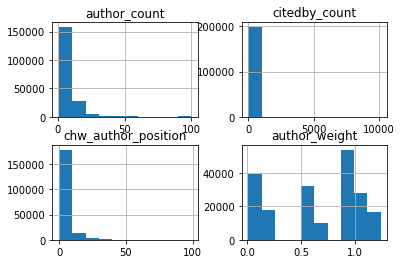

In [22]:
df_pos[['author_count', 'citedby_count', 'chw_author_position', 'author_weight']].hist()

In [23]:
df_pos = df_pos.groupby('Auid', as_index=False).agg(
    {
        'author_count': ['mean', 'median'],
        'citedby_count': ['mean', 'median'],
        'chw_author_position': ['mean', 'median'],
        'author_weight': ['mean', 'median'],
        'first_author': 'sum',
        'last_author': 'sum'
    }
)

# change the multiindex columns to a simple index
df_pos.columns = ['_'.join(col).strip() for col in df_pos.columns.values]

In [24]:
df_pos

,Auid_,author_count_mean,author_count_median,citedby_count_mean,citedby_count_median,chw_author_position_mean,chw_author_position_median,author_weight_mean,author_weight_median,first_author_sum,last_author_sum
0,6503856044,11.166667,10.0,23.114583,7.0,4.572917,3.0,0.355223,0.133918,7,7
1,6503905253,8.250000,8.0,41.062500,15.5,3.281250,2.0,0.618835,0.619379,9,5
2,6503911165,24.380952,8.0,28.095238,21.0,14.523810,4.0,0.384260,0.125299,3,1
3,6504148317,10.571429,4.0,54.857143,11.0,5.142857,2.0,0.787197,0.986762,0,4
4,6504169150,11.978261,7.0,30.195652,4.5,2.260870,2.0,0.575255,0.600268,17,4
...,...,...,...,...,...,...,...,...,...,...,...
2517,57248713000,16.000000,16.0,0.000000,0.0,12.000000,12.0,0.062814,0.062814,0,0
2518,57249145700,7.000000,7.0,0.000000,0.0,3.000000,3.0,0.143432,0.143432,0,0
2519,57262851900,6.000000,6.0,0.000000,0.0,0.000000,0.0,0.985012,0.985012,1,0
2520,57266821900,3.000000,3.0,0.000000,0.0,2.000000,2.0,1.000000,1.000000,0,1


# Get publication counts by type

In [25]:
df = pd.concat(
    [
        df_pub,
        pd.get_dummies(df_pub['subtypeDescription'])
    ],
    axis = 1
)
df

,Auid,eid,doi,pii,pubmed_id,title,subtype,subtypeDescription,creator,afid,...,Conference Paper,Conference Review,Data Paper,Editorial,Erratum,Letter,Note,Retracted,Review,Short Survey
0,7007033627,2-s2.0-85099771687,10.1111/trf.16273,NaN,33481275.0,Hypothermic storage of leukoreduced red blood ...,ar,Article,Mykhailova O.,60030835;60017305;100848647,...,0,0,0,0,0,0,0,0,0,0
1,7007033627,2-s2.0-85101536878,10.1136/bmjopen-2021-049598,NaN,33622960.0,"Pragmatic, double-blind, randomised trial eval...",ar,Article,Fergusson D.A.,60085927;60028897;60017305;60013175;60009507;6...,...,0,0,0,0,0,0,0,0,0,0
2,7007033627,2-s2.0-85108712603,10.1021/acs.biomac.1c00671,NaN,34101413.0,Erratum: Trehalose-Based Polyethers for Cryopr...,er,Erratum,Diaz-Dussan D.,NaN,...,0,0,0,0,1,0,0,0,0,0
3,7007033627,2-s2.0-85097079450,10.1016/j.transci.2020.103020,S1473050220303438,33246838.0,Emerging use of machine learning and advanced ...,re,Review,Sebastian J.A.,60193797;60089742;60085802;60030838;60030835;6...,...,0,0,0,0,0,0,0,0,1,0
4,7007033627,2-s2.0-85092567077,10.1111/trf.16136,NaN,33009667.0,Evaluating blood product quality post expiry t...,le,Letter,Turner T.R.,60017305,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199262,57248713000,2-s2.0-85114349367,10.1016/j.jaac.2021.07.823,S0890856721013162,34391859.0,Distinguishing and Managing Acute-Onset Comple...,le,Letter,McGuire J.F.,60027550;60025488;60017031;60015720;60015609;6...,...,0,0,0,0,0,1,0,0,0,0
199263,57249145700,2-s2.0-85114437047,10.1159/000518173,NaN,NaN,Diagnostic Dilemma in an Adolescent Girl with ...,ar,Article,Bamhraz A.A.,60031828;60026278,...,0,0,0,0,0,0,0,0,0,0
199264,57262851900,2-s2.0-85115150056,10.3390/healthcare7010003,NaN,NaN,Clinical use of an order protocol for distress...,ar,Article,Marquis M.A.,60005610,...,0,0,0,0,0,0,0,0,0,0
199265,57266821900,2-s2.0-85115384392,10.1016/j.annemergmed.2021.04.003,S0196064421002869,NaN,Adolescent Male With Eye Pain,sh,Short Survey,Pancer Z.,60030319,...,0,0,0,0,0,0,0,0,0,1


# Get SCImago Journal Rank (SJR) for publication sources

In [26]:
journals = pd.read_csv('../Datasets/scimag_journals2020.csv', delimiter = ';', low_memory = False)

# get three columns of interest
df_jrn = journals[['Title', 'SJR', 'Categories', 'H index']].rename(columns = {'H index': 'journal_h_index'})

df2 = df.merge(df_jrn, left_on = 'publicationName', right_on = 'Title')

# convert 0,xx to 0.xx
df2['SJR'] = df2['SJR'].apply(convert_eu_to_float)

df2.head()

,Auid,eid,doi,pii,pubmed_id,title,subtype,subtypeDescription,creator,afid,...,Erratum,Letter,Note,Retracted,Review,Short Survey,Title,SJR,Categories,journal_h_index
0,7007033627,2-s2.0-85099771687,10.1111/trf.16273,NaN,33481275.0,Hypothermic storage of leukoreduced red blood ...,ar,Article,Mykhailova O.,60030835;60017305;100848647,...,0,0,0,0,0,0,Transfusion,1.045,Hematology (Q2); Immunology (Q2); Immunology a...,132
1,7007033627,2-s2.0-85092567077,10.1111/trf.16136,NaN,33009667.0,Evaluating blood product quality post expiry t...,le,Letter,Turner T.R.,60017305,...,0,1,0,0,0,0,Transfusion,1.045,Hematology (Q2); Immunology (Q2); Immunology a...,132
2,7007033627,2-s2.0-85089481768,10.1111/trf.16017,NaN,32812244.0,Donor-dependent aging of young and old red blo...,ar,Article,Mykhailova O.,60030835;60028392;60017305,...,0,0,0,0,0,0,Transfusion,1.045,Hematology (Q2); Immunology (Q2); Immunology a...,132
3,7007033627,2-s2.0-85075482940,10.1111/trf.15590,NaN,31756004.0,Platelet vesicles are potent inflammatory medi...,ar,Article,Almizraq R.J.,60030835;60017305,...,0,0,0,0,0,0,Transfusion,1.045,Hematology (Q2); Immunology (Q2); Immunology a...,132
4,7007033627,2-s2.0-85075191276,10.1111/trf.15589,NaN,31724744.0,Evaluating the quality of red blood cell conce...,ar,Article,Turner T.R.,60030835;60017305,...,0,0,0,0,0,0,Transfusion,1.045,Hematology (Q2); Immunology (Q2); Immunology a...,132


# Group the publication statistics by author

In [27]:
# group the metrics by author
df3 = df2.groupby('Auid', as_index = False).agg(
    {
        'openaccess': 'sum',
        'Article': 'sum',
#         'Book': 'sum',
#         'Book Chapter': 'sum',
#         'Chapter': 'sum',
#         'Conference Paper': 'sum',
#         'Data Paper': 'sum',
#         'Editorial': 'sum',
#         'Erratum': 'sum',
#         'Letter': 'sum',
#         'Note': 'sum',
#         'Retracted': 'sum',
#         'Review': 'sum',
#         'Short Survey': 'sum',
        'SJR': ['median', 'mean'],
        'journal_h_index': ['median', 'mean'],
    }
)

# change the multiindex columns to a simple index
df3.columns = ['_'.join(col).strip() for col in df3.columns.values]

df3.info()
df3.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2514 entries, 0 to 2513
Data columns (total 7 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Auid_                   2514 non-null   int64  
 1   openaccess_sum          2514 non-null   int64  
 2   Article_sum             2514 non-null   float64
 3   SJR_median              2514 non-null   float64
 4   SJR_mean                2514 non-null   float64
 5   journal_h_index_median  2514 non-null   float64
 6   journal_h_index_mean    2514 non-null   float64
dtypes: float64(5), int64(2)
memory usage: 157.1 KB


,Auid_,openaccess_sum,Article_sum,SJR_median,SJR_mean,journal_h_index_median,journal_h_index_mean
0,6503856044,32,64.0,1.116,2.129307,105.0,145.443182
1,6503905253,13,19.0,1.779,2.286880,186.0,223.680000
2,6503911165,2,15.0,1.082,1.509500,120.5,171.750000
3,6504148317,0,5.0,0.805,3.676500,99.5,155.666667
4,6504169150,20,31.0,0.949,1.365558,60.0,100.883721


# Merge journal stats with authorship stats

In [28]:
df3 = df3.merge(df_pos, on='Auid_', how='inner')
df3

,Auid_,openaccess_sum,Article_sum,SJR_median,SJR_mean,journal_h_index_median,journal_h_index_mean,author_count_mean,author_count_median,citedby_count_mean,citedby_count_median,chw_author_position_mean,chw_author_position_median,author_weight_mean,author_weight_median,first_author_sum,last_author_sum
0,6503856044,32,64.0,1.116,2.129307,105.0,145.443182,11.166667,10.0,23.114583,7.0,4.572917,3.0,0.355223,0.133918,7,7
1,6503905253,13,19.0,1.779,2.286880,186.0,223.680000,8.250000,8.0,41.062500,15.5,3.281250,2.0,0.618835,0.619379,9,5
2,6503911165,2,15.0,1.082,1.509500,120.5,171.750000,24.380952,8.0,28.095238,21.0,14.523810,4.0,0.384260,0.125299,3,1
3,6504148317,0,5.0,0.805,3.676500,99.5,155.666667,10.571429,4.0,54.857143,11.0,5.142857,2.0,0.787197,0.986762,0,4
4,6504169150,20,31.0,0.949,1.365558,60.0,100.883721,11.978261,7.0,30.195652,4.5,2.260870,2.0,0.575255,0.600268,17,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2509,57241564300,0,1.0,0.900,0.900000,37.0,37.000000,2.000000,2.0,0.000000,0.0,1.000000,1.0,1.241007,1.241007,0,1
2510,57248713000,0,0.0,3.216,3.216000,243.0,243.000000,16.000000,16.0,0.000000,0.0,12.000000,12.0,0.062814,0.062814,0,0
2511,57249145700,0,1.0,0.951,0.951000,72.0,72.000000,7.000000,7.0,0.000000,0.0,3.000000,3.0,0.143432,0.143432,0,0
2512,57266821900,1,0.0,1.241,1.241000,153.0,153.000000,3.000000,3.0,0.000000,0.0,2.000000,2.0,1.000000,1.000000,0,1


# Get author profiles

In [29]:
df_profiles = pd.read_json('../Datasets/chw_author_profiles_jan12.json')
# df_ucal = pd.read_excel('../Datasets/ucalgary_author_profiles.xlsx')

# df_ucal.info()
df_profiles.info()

# df_ucal.head()
df_profiles.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2493 entries, 0 to 2492
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Auid                     2493 non-null   int64  
 1   filled_cum_citations     2493 non-null   object 
 2   mean_citations_per_year  2493 non-null   float64
 3   citation_count           2493 non-null   int64  
 4   cited_by_count           2493 non-null   int64  
 5   coauthor_count           2493 non-null   int64  
 6   classificationgroup      2493 non-null   object 
 7   document_count           2493 non-null   int64  
 8   given_name               2493 non-null   object 
 9   h_index                  2493 non-null   int64  
 10  indexed_name             2493 non-null   object 
 11  publication_range        2493 non-null   object 
 12  subject_areas            2493 non-null   object 
 13  surname                  2493 non-null   object 
dtypes: float64(1), int64(6),

,Auid,filled_cum_citations,mean_citations_per_year,citation_count,cited_by_count,coauthor_count,classificationgroup,document_count,given_name,h_index,indexed_name,publication_range,subject_areas,surname
0,6603220065,"[13.0, 106.0, 214.0, 346.0, 443.0, 561.0, 622....",74.000000,1038,800,239,"[(2737, 2), (2102, 4), (2300, 1), (3504, 2), (...",168,Samer M.,18,Adeeb S.,"(2004, 2021)","[Subjectarea(area='Physiology (medical)', abbr...",Adeeb
1,7007033627,"[106.0, 206.0, 494.0, 707.0, 902.0, 1423.0, 17...",190.090909,3837,2552,476,"[(1303, 11), (2720, 71), (2507, 1), (1602, 1),...",166,Jason P.,35,Acker J.,"(1996, 2021)","[Subjectarea(area='Biochemistry', abbreviation...",Acker
2,16688012700,"[0.0, 64.0, 64.0, 98.0, 101.0, 122.0, 128.0, 1...",19.000000,1702,1361,66,"[(2400, 5), (2721, 1), (1101, 1), (3003, 8), (...",65,Babita,23,Agrawal B.,"(1991, 2020)",[Subjectarea(area='Immunology and Microbiology...,Agrawal
3,12902675100,"[46.0, 59.0, 79.0, 114.0, 121.0, 160.0, 232.0,...",23.545455,287,170,76,"[(1709, 4), (1702, 7), (3319, 1), (2735, 2), (...",46,Kim D.,9,Adams K.,"(2009, 2020)",[Subjectarea(area='Human-Computer Interaction'...,Adams
4,55366878700,"[121.0, 249.0, 386.0, 644.0, 777.0, 896.0, 114...",133.454545,1643,1273,438,"[(2908, 1), (2406, 2), (1313, 2), (2614, 1), (...",128,Samina,24,Ali S.,"(2003, 2021)","[Subjectarea(area='Fundamentals and Skills', a...",Ali


# Merge with CHW ids to get affiliation

In [30]:
affils = pd.read_excel('../Datasets/chw_ids.xlsx', index_col=0)
affils.drop('OBRIEN', axis = 1, inplace = True)
affils.info()
affils.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2524 entries, 0 to 2523
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   Auid      2524 non-null   int64
 1   WCHRI     2524 non-null   int64
 2   ACHRI     2524 non-null   int64
 3   BCCHR     2524 non-null   int64
 4   CHRIM     2524 non-null   int64
 5   CHUSJ     2524 non-null   int64
 6   MCMASTER  2524 non-null   int64
 7   Sickkids  2524 non-null   int64
dtypes: int64(8)
memory usage: 177.5 KB


,Auid,WCHRI,ACHRI,BCCHR,CHRIM,CHUSJ,MCMASTER,Sickkids
0,7007033627,1,0,0,0,0,0,0
1,12902675100,1,0,0,0,0,0,0
2,6603220065,1,0,0,0,0,0,0
3,16688012700,1,0,0,0,0,0,0
4,7003415672,1,0,0,0,0,0,0


In [32]:
affils.drop_duplicates(inplace=True)

In [33]:
af = affils.melt(
    'Auid', 
    var_name = 'affil'
).query(
    'value == 1'
).groupby(
    'Auid'
)[
    'affil'
].apply(
    ', '.join
).reset_index()

df_profiles = pd.merge(df_profiles, af, on = 'Auid')

# remove overlap between UCalgary and CHW authors
# df_ucal = df_ucal[~df_ucal['Auid'].isin(df_profiles['Auid'])]

# combine the profile dataframes
# df_profiles = pd.concat([df_profiles, df_ucal])
df_profiles.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2233 entries, 0 to 2232
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Auid                     2233 non-null   int64  
 1   filled_cum_citations     2233 non-null   object 
 2   mean_citations_per_year  2233 non-null   float64
 3   citation_count           2233 non-null   int64  
 4   cited_by_count           2233 non-null   int64  
 5   coauthor_count           2233 non-null   int64  
 6   classificationgroup      2233 non-null   object 
 7   document_count           2233 non-null   int64  
 8   given_name               2233 non-null   object 
 9   h_index                  2233 non-null   int64  
 10  indexed_name             2233 non-null   object 
 11  publication_range        2233 non-null   object 
 12  subject_areas            2233 non-null   object 
 13  surname                  2233 non-null   object 
 14  affil                   

# Count current and past affiliations

In [34]:
# count the past and present affiliations
# df_profiles['total_current_affiliations'] = df_profiles['affiliation_current'].str.findall('(Affiliation)\(').apply(count_affils)
# df_profiles['total_past_affiliations'] = df_profiles['affiliation_history'].str.findall('(Affiliation)\(').apply(count_affils)

# get the number of years publishing
df_profiles['first_publication'] = df_profiles['publication_range'].str.extract('\(([0-9]*), ').astype(int)
df_profiles['last_publication'] = df_profiles['publication_range'].str.extract(', ([0-9]*)\)').astype(int)

df_profiles['publication_duration'] = df_profiles['last_publication'] - df_profiles['first_publication']

# get dummy variable for whether the orcid was reported or not
# df_profiles['ORCID'] = np.where(df_profiles['orcid'].notna(), 1, 0)

df_profiles.head()

,Auid,filled_cum_citations,mean_citations_per_year,citation_count,cited_by_count,coauthor_count,classificationgroup,document_count,given_name,h_index,indexed_name,publication_range,subject_areas,surname,affil,first_publication,last_publication,publication_duration
0,6603220065,"[13.0, 106.0, 214.0, 346.0, 443.0, 561.0, 622....",74.000000,1038,800,239,"[(2737, 2), (2102, 4), (2300, 1), (3504, 2), (...",168,Samer M.,18,Adeeb S.,"(2004, 2021)","[Subjectarea(area='Physiology (medical)', abbr...",Adeeb,WCHRI,2004,2021,17
1,7007033627,"[106.0, 206.0, 494.0, 707.0, 902.0, 1423.0, 17...",190.090909,3837,2552,476,"[(1303, 11), (2720, 71), (2507, 1), (1602, 1),...",166,Jason P.,35,Acker J.,"(1996, 2021)","[Subjectarea(area='Biochemistry', abbreviation...",Acker,WCHRI,1996,2021,25
2,16688012700,"[0.0, 64.0, 64.0, 98.0, 101.0, 122.0, 128.0, 1...",19.000000,1702,1361,66,"[(2400, 5), (2721, 1), (1101, 1), (3003, 8), (...",65,Babita,23,Agrawal B.,"(1991, 2020)",[Subjectarea(area='Immunology and Microbiology...,Agrawal,WCHRI,1991,2020,29
3,12902675100,"[46.0, 59.0, 79.0, 114.0, 121.0, 160.0, 232.0,...",23.545455,287,170,76,"[(1709, 4), (1702, 7), (3319, 1), (2735, 2), (...",46,Kim D.,9,Adams K.,"(2009, 2020)",[Subjectarea(area='Human-Computer Interaction'...,Adams,WCHRI,2009,2020,11
4,55366878700,"[121.0, 249.0, 386.0, 644.0, 777.0, 896.0, 114...",133.454545,1643,1273,438,"[(2908, 1), (2406, 2), (1313, 2), (2614, 1), (...",128,Samina,24,Ali S.,"(2003, 2021)","[Subjectarea(area='Fundamentals and Skills', a...",Ali,WCHRI,2003,2021,18


In [35]:
df_profiles.columns

Index(['Auid', 'filled_cum_citations', 'mean_citations_per_year',
       'citation_count', 'cited_by_count', 'coauthor_count',
       'classificationgroup', 'document_count', 'given_name', 'h_index',
       'indexed_name', 'publication_range', 'subject_areas', 'surname',
       'affil', 'first_publication', 'last_publication',
       'publication_duration'],
      dtype='object')

In [36]:
df_profiles.drop(
    [
        'given_name',
        'publication_range',
        'surname',
        'first_publication',
        'last_publication'
    ], 
    axis = 1, 
    inplace = True
)

df_profiles.head()

,Auid,filled_cum_citations,mean_citations_per_year,citation_count,cited_by_count,coauthor_count,classificationgroup,document_count,h_index,indexed_name,subject_areas,affil,publication_duration
0,6603220065,"[13.0, 106.0, 214.0, 346.0, 443.0, 561.0, 622....",74.000000,1038,800,239,"[(2737, 2), (2102, 4), (2300, 1), (3504, 2), (...",168,18,Adeeb S.,"[Subjectarea(area='Physiology (medical)', abbr...",WCHRI,17
1,7007033627,"[106.0, 206.0, 494.0, 707.0, 902.0, 1423.0, 17...",190.090909,3837,2552,476,"[(1303, 11), (2720, 71), (2507, 1), (1602, 1),...",166,35,Acker J.,"[Subjectarea(area='Biochemistry', abbreviation...",WCHRI,25
2,16688012700,"[0.0, 64.0, 64.0, 98.0, 101.0, 122.0, 128.0, 1...",19.000000,1702,1361,66,"[(2400, 5), (2721, 1), (1101, 1), (3003, 8), (...",65,23,Agrawal B.,[Subjectarea(area='Immunology and Microbiology...,WCHRI,29
3,12902675100,"[46.0, 59.0, 79.0, 114.0, 121.0, 160.0, 232.0,...",23.545455,287,170,76,"[(1709, 4), (1702, 7), (3319, 1), (2735, 2), (...",46,9,Adams K.,[Subjectarea(area='Human-Computer Interaction'...,WCHRI,11
4,55366878700,"[121.0, 249.0, 386.0, 644.0, 777.0, 896.0, 114...",133.454545,1643,1273,438,"[(2908, 1), (2406, 2), (1313, 2), (2614, 1), (...",128,24,Ali S.,"[Subjectarea(area='Fundamentals and Skills', a...",WCHRI,18


# Compute the linear growth rate in cumulative citations

In [37]:
df_profiles.loc[0, 'filled_cum_citations']

[13.0, 106.0, 214.0, 346.0, 443.0, 561.0, 622.0, 669.0, 755.0, 810.0, 814.0]

In [38]:
def linear_growth(col):
    """ Accepts a column of cumulative summed values and approximates
        the linear growth rate. The growth rate is approximated over
        the period of 2011-2021 as follows:
        
        - if all elements are nonzero, compute (max - min)/length
        - if all elements are zero, return 0
        - if there are leading zeros
            - find the index of the first nonzero element
            - max is the last element of the array
            - min is the last zero before the nonzero element(s)
            - compute (max - min)/len(nonzero)
    """
    col = np.array(col)
       
    # find if all entries are zero
    if int(sum(col)) == 0:
        return 0
    
    try:
        # find the zeros - col is integer valued
        zero_index = np.argwhere(col < 1)[0][0]
        
        return (np.max(col) - col[zero_index])/len(np.argwhere(col > 0) + 1)
        
    except IndexError:  # this happens when no zeros are found
        return (np.max(col) - np.min(col))/len(col)
    

In [39]:
df_profiles['growth_rate'] = df_profiles['filled_cum_citations'].apply(linear_growth)
df_profiles.head()

,Auid,filled_cum_citations,mean_citations_per_year,citation_count,cited_by_count,coauthor_count,classificationgroup,document_count,h_index,indexed_name,subject_areas,affil,publication_duration,growth_rate
0,6603220065,"[13.0, 106.0, 214.0, 346.0, 443.0, 561.0, 622....",74.000000,1038,800,239,"[(2737, 2), (2102, 4), (2300, 1), (3504, 2), (...",168,18,Adeeb S.,"[Subjectarea(area='Physiology (medical)', abbr...",WCHRI,17,72.818182
1,7007033627,"[106.0, 206.0, 494.0, 707.0, 902.0, 1423.0, 17...",190.090909,3837,2552,476,"[(1303, 11), (2720, 71), (2507, 1), (1602, 1),...",166,35,Acker J.,"[Subjectarea(area='Biochemistry', abbreviation...",WCHRI,25,180.454545
2,16688012700,"[0.0, 64.0, 64.0, 98.0, 101.0, 122.0, 128.0, 1...",19.000000,1702,1361,66,"[(2400, 5), (2721, 1), (1101, 1), (3003, 8), (...",65,23,Agrawal B.,[Subjectarea(area='Immunology and Microbiology...,WCHRI,29,20.900000
3,12902675100,"[46.0, 59.0, 79.0, 114.0, 121.0, 160.0, 232.0,...",23.545455,287,170,76,"[(1709, 4), (1702, 7), (3319, 1), (2735, 2), (...",46,9,Adams K.,[Subjectarea(area='Human-Computer Interaction'...,WCHRI,11,19.363636
4,55366878700,"[121.0, 249.0, 386.0, 644.0, 777.0, 896.0, 114...",133.454545,1643,1273,438,"[(2908, 1), (2406, 2), (1313, 2), (2614, 1), (...",128,24,Ali S.,"[Subjectarea(area='Fundamentals and Skills', a...",WCHRI,18,122.454545


In [40]:
df_profiles['growth_rate'].max()

9630.454545454546

In [41]:
df_profiles['growth_rate'].fillna(0, inplace=True)
df_profiles['growth_rate'].replace({np.inf: 0}, inplace=True)

In [42]:
df_profiles

,Auid,filled_cum_citations,mean_citations_per_year,citation_count,cited_by_count,coauthor_count,classificationgroup,document_count,h_index,indexed_name,subject_areas,affil,publication_duration,growth_rate
0,6603220065,"[13.0, 106.0, 214.0, 346.0, 443.0, 561.0, 622....",74.000000,1038,800,239,"[(2737, 2), (2102, 4), (2300, 1), (3504, 2), (...",168,18,Adeeb S.,"[Subjectarea(area='Physiology (medical)', abbr...",WCHRI,17,72.818182
1,7007033627,"[106.0, 206.0, 494.0, 707.0, 902.0, 1423.0, 17...",190.090909,3837,2552,476,"[(1303, 11), (2720, 71), (2507, 1), (1602, 1),...",166,35,Acker J.,"[Subjectarea(area='Biochemistry', abbreviation...",WCHRI,25,180.454545
2,16688012700,"[0.0, 64.0, 64.0, 98.0, 101.0, 122.0, 128.0, 1...",19.000000,1702,1361,66,"[(2400, 5), (2721, 1), (1101, 1), (3003, 8), (...",65,23,Agrawal B.,[Subjectarea(area='Immunology and Microbiology...,WCHRI,29,20.900000
3,12902675100,"[46.0, 59.0, 79.0, 114.0, 121.0, 160.0, 232.0,...",23.545455,287,170,76,"[(1709, 4), (1702, 7), (3319, 1), (2735, 2), (...",46,9,Adams K.,[Subjectarea(area='Human-Computer Interaction'...,WCHRI,11,19.363636
4,55366878700,"[121.0, 249.0, 386.0, 644.0, 777.0, 896.0, 114...",133.454545,1643,1273,438,"[(2908, 1), (2406, 2), (1313, 2), (2614, 1), (...",128,24,Ali S.,"[Subjectarea(area='Fundamentals and Skills', a...",WCHRI,18,122.454545
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2228,57226682225,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.000000,0,0,25,"[(2716, 1), (2736, 1), (2700, 1)]",1,0,McLean L.,"[Subjectarea(area='Genetics (clinical)', abbre...",Sickkids,0,0.000000
2229,57283733600,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.000000,0,0,7,"[(2720, 1)]",1,0,Patterson S.,"[Subjectarea(area='Hematology', abbreviation='...",MCMASTER,0,0.000000
2230,57262851900,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.000000,0,0,5,"[(2911, 1), (2719, 1), (2718, 1), (3605, 1)]",1,0,Marquis M.,"[Subjectarea(area='Leadership and Management',...",CHUSJ,0,0.000000
2231,57249145700,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.272727,0,0,6,"[(2748, 1), (2737, 1), (2727, 1), (1314, 1)]",1,0,Rodrigues A.,"[Subjectarea(area='Urology', abbreviation='MED...",MCMASTER,0,3.000000


# Merge the author profile stats with stats from publications

In [43]:
df3

,Auid_,openaccess_sum,Article_sum,SJR_median,SJR_mean,journal_h_index_median,journal_h_index_mean,author_count_mean,author_count_median,citedby_count_mean,citedby_count_median,chw_author_position_mean,chw_author_position_median,author_weight_mean,author_weight_median,first_author_sum,last_author_sum
0,6503856044,32,64.0,1.116,2.129307,105.0,145.443182,11.166667,10.0,23.114583,7.0,4.572917,3.0,0.355223,0.133918,7,7
1,6503905253,13,19.0,1.779,2.286880,186.0,223.680000,8.250000,8.0,41.062500,15.5,3.281250,2.0,0.618835,0.619379,9,5
2,6503911165,2,15.0,1.082,1.509500,120.5,171.750000,24.380952,8.0,28.095238,21.0,14.523810,4.0,0.384260,0.125299,3,1
3,6504148317,0,5.0,0.805,3.676500,99.5,155.666667,10.571429,4.0,54.857143,11.0,5.142857,2.0,0.787197,0.986762,0,4
4,6504169150,20,31.0,0.949,1.365558,60.0,100.883721,11.978261,7.0,30.195652,4.5,2.260870,2.0,0.575255,0.600268,17,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2509,57241564300,0,1.0,0.900,0.900000,37.0,37.000000,2.000000,2.0,0.000000,0.0,1.000000,1.0,1.241007,1.241007,0,1
2510,57248713000,0,0.0,3.216,3.216000,243.0,243.000000,16.000000,16.0,0.000000,0.0,12.000000,12.0,0.062814,0.062814,0,0
2511,57249145700,0,1.0,0.951,0.951000,72.0,72.000000,7.000000,7.0,0.000000,0.0,3.000000,3.0,0.143432,0.143432,0,0
2512,57266821900,1,0.0,1.241,1.241000,153.0,153.000000,3.000000,3.0,0.000000,0.0,2.000000,2.0,1.000000,1.000000,0,1


In [44]:
df_stats = pd.merge(df_profiles, df3, left_on = 'Auid', right_on = 'Auid_')
df_stats.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2226 entries, 0 to 2225
Data columns (total 31 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Auid                        2226 non-null   int64  
 1   filled_cum_citations        2226 non-null   object 
 2   mean_citations_per_year     2226 non-null   float64
 3   citation_count              2226 non-null   int64  
 4   cited_by_count              2226 non-null   int64  
 5   coauthor_count              2226 non-null   int64  
 6   classificationgroup         2226 non-null   object 
 7   document_count              2226 non-null   int64  
 8   h_index                     2226 non-null   int64  
 9   indexed_name                2226 non-null   object 
 10  subject_areas               2226 non-null   object 
 11  affil                       2226 non-null   object 
 12  publication_duration        2226 non-null   int64  
 13  growth_rate                 2226 

In [45]:
df_stats

,Auid,filled_cum_citations,mean_citations_per_year,citation_count,cited_by_count,coauthor_count,classificationgroup,document_count,h_index,indexed_name,...,author_count_mean,author_count_median,citedby_count_mean,citedby_count_median,chw_author_position_mean,chw_author_position_median,author_weight_mean,author_weight_median,first_author_sum,last_author_sum
0,6603220065,"[13.0, 106.0, 214.0, 346.0, 443.0, 561.0, 622....",74.000000,1038,800,239,"[(2737, 2), (2102, 4), (2300, 1), (3504, 2), (...",168,18,Adeeb S.,...,5.113095,5.0,6.178571,2.0,3.107143,3.0,0.788131,0.984583,11,79
1,7007033627,"[106.0, 206.0, 494.0, 707.0, 902.0, 1423.0, 17...",190.090909,3837,2552,476,"[(1303, 11), (2720, 71), (2507, 1), (1602, 1),...",166,35,Acker J.,...,6.287425,5.0,23.035928,13.0,3.305389,2.0,0.762061,0.985012,18,70
2,16688012700,"[0.0, 64.0, 64.0, 98.0, 101.0, 122.0, 128.0, 1...",19.000000,1702,1361,66,"[(2400, 5), (2721, 1), (1101, 1), (3003, 8), (...",65,23,Agrawal B.,...,4.723077,5.0,26.184615,14.0,2.384615,2.0,0.766865,0.985616,16,24
3,12902675100,"[46.0, 59.0, 79.0, 114.0, 121.0, 160.0, 232.0,...",23.545455,287,170,76,"[(1709, 4), (1702, 7), (3319, 1), (2735, 2), (...",46,9,Adams K.,...,4.608696,4.0,6.282609,3.0,1.869565,1.0,0.785031,0.811536,11,10
4,55366878700,"[121.0, 249.0, 386.0, 644.0, 777.0, 896.0, 114...",133.454545,1643,1273,438,"[(2908, 1), (2406, 2), (1313, 2), (2614, 1), (...",128,24,Ali S.,...,9.640625,8.0,12.875000,5.5,4.187500,2.5,0.620556,0.619379,22,38
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2221,57241564300,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.000000,0,0,1,"[(1310, 1), (2712, 1), (2724, 1)]",1,0,Geddie H.,...,2.000000,2.0,0.000000,0.0,1.000000,1.0,1.241007,1.241007,0,1
2222,57226682225,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.000000,0,0,25,"[(2716, 1), (2736, 1), (2700, 1)]",1,0,McLean L.,...,26.000000,26.0,0.000000,0.0,11.000000,11.0,0.038462,0.038462,0,0
2223,57283733600,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.000000,0,0,7,"[(2720, 1)]",1,0,Patterson S.,...,8.000000,8.0,0.000000,0.0,1.000000,1.0,0.562500,0.562500,0,0
2224,57249145700,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.272727,0,0,6,"[(2748, 1), (2737, 1), (2727, 1), (1314, 1)]",1,0,Rodrigues A.,...,7.000000,7.0,0.000000,0.0,3.000000,3.0,0.143432,0.143432,0,0


In [46]:
top10 = df_stats['cited_by_count'].quantile(q=.9)

df_stats[df_stats['cited_by_count'] >= top10]

,Auid,filled_cum_citations,mean_citations_per_year,citation_count,cited_by_count,coauthor_count,classificationgroup,document_count,h_index,indexed_name,...,author_count_mean,author_count_median,citedby_count_mean,citedby_count_median,chw_author_position_mean,chw_author_position_median,author_weight_mean,author_weight_median,first_author_sum,last_author_sum
17,7003777149,"[837.0, 2148.0, 4030.0, 5810.0, 8297.0, 9492.0...",1280.818182,24365,16197,3591,"[(1502, 1), (2736, 4), (2746, 8), (1314, 1), (...",448,79,Bagshaw S.,...,9.825893,6.0,54.511161,20.0,3.786996,2.0,0.697793,0.983649,112,132
19,7006668487,"[5250.0, 7043.0, 9853.0, 11171.0, 12029.0, 129...",1504.545455,27439,14392,903,"[(2732, 30), (2914, 2), (2746, 12), (3003, 2),...",346,73,Baracos V.,...,6.514451,6.0,79.580925,28.0,3.442197,3.0,0.710343,0.983731,57,141
21,35507973100,"[1057.0, 1876.0, 2232.0, 2565.0, 2769.0, 2910....",305.545455,15441,11477,368,"[(2712, 4), (3204, 1), (1203, 1), (1310, 4), (...",168,49,Beaulieu C.,...,5.745562,5.0,91.467456,26.0,3.213018,3.0,0.752068,0.984262,15,81
30,6603756781,"[179.0, 406.0, 1204.0, 2442.0, 2640.0, 2824.0,...",355.818182,6488,5579,622,"[(2730, 85), (2700, 3), (2502, 1), (3004, 3), ...",159,36,Brandwein J.,...,9.981250,9.0,40.712500,16.5,4.356250,4.0,0.478015,0.543561,19,29
67,7005933822,"[530.0, 1099.0, 1937.0, 2281.0, 2629.0, 2961.0...",326.818182,9957,7219,590,"[(2400, 1), (2704, 1), (2737, 33), (1312, 13),...",270,56,Davidge S.,...,5.815498,5.0,36.797048,22.0,3.571956,3.0,0.789255,0.985616,22,136
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2099,57203102859,"[200.0, 712.0, 1104.0, 1514.0, 1946.0, 2678.0,...",296.727273,15185,10633,1159,"[(2739, 17), (2917, 8), (2712, 11), (2746, 6),...",489,59,Barr R.,...,6.192229,4.0,31.053170,12.0,2.826176,2.0,0.818388,0.985616,179,193
2110,57204409408,"[490.0, 800.0, 2820.0, 3082.0, 3568.0, 3569.0,...",356.909091,8243,6978,694,"[(2800, 28), (2722, 1), (2804, 14), (2700, 7),...",108,35,Hazrati L.,...,9.388889,5.5,76.324074,14.0,4.722222,2.0,0.629795,0.600268,17,26
2111,57204345472,"[648.0, 1151.0, 1309.0, 2336.0, 11086.0, 13514...",1583.090909,16657,15226,2893,"[(2742, 2), (2730, 2), (2737, 1), (2713, 6), (...",124,38,DeVeber G.,...,26.935484,9.0,134.330645,13.0,10.739130,5.0,0.488228,0.550000,6,31
2150,57211089486,"[242.0, 630.0, 806.0, 981.0, 1216.0, 1239.0, 1...",119.909091,10745,7448,808,"[(2721, 34), (1305, 1), (1303, 9), (1100, 3), ...",243,53,Álvarez F.,...,7.032922,5.0,44.218107,14.0,3.442149,3.0,0.799634,0.985616,42,133


# Save the data for PCA

In [47]:
df_stats.columns

Index(['Auid', 'filled_cum_citations', 'mean_citations_per_year',
       'citation_count', 'cited_by_count', 'coauthor_count',
       'classificationgroup', 'document_count', 'h_index', 'indexed_name',
       'subject_areas', 'affil', 'publication_duration', 'growth_rate',
       'Auid_', 'openaccess_sum', 'Article_sum', 'SJR_median', 'SJR_mean',
       'journal_h_index_median', 'journal_h_index_mean', 'author_count_mean',
       'author_count_median', 'citedby_count_mean', 'citedby_count_median',
       'chw_author_position_mean', 'chw_author_position_median',
       'author_weight_mean', 'author_weight_median', 'first_author_sum',
       'last_author_sum'],
      dtype='object')

In [48]:
df_stats.dropna(inplace=True)

In [49]:
df_stats.drop(
    [
        'Auid_',
        'indexed_name',
        'subject_areas',
        'classificationgroup',
        'filled_cum_citations'
    ],
    axis=1,
    inplace=True
)

In [50]:
df_stats.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2225 entries, 0 to 2225
Data columns (total 26 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Auid                        2225 non-null   int64  
 1   mean_citations_per_year     2225 non-null   float64
 2   citation_count              2225 non-null   int64  
 3   cited_by_count              2225 non-null   int64  
 4   coauthor_count              2225 non-null   int64  
 5   document_count              2225 non-null   int64  
 6   h_index                     2225 non-null   int64  
 7   affil                       2225 non-null   object 
 8   publication_duration        2225 non-null   int64  
 9   growth_rate                 2225 non-null   float64
 10  openaccess_sum              2225 non-null   int64  
 11  Article_sum                 2225 non-null   float64
 12  SJR_median                  2225 non-null   float64
 13  SJR_mean                    2225 

# Fix the doubled affiliations

In [51]:
df_stats['affil'].unique()

array(['WCHRI', 'WCHRI, ACHRI', 'BCCHR', 'ACHRI', 'MCMASTER', 'Sickkids',
       'CHUSJ', 'CHRIM', 'MCMASTER, Sickkids', 'BCCHR, Sickkids'],
      dtype=object)

In [52]:
df_stats['affil'].replace({'MCMASTER, Sickkids': 'McMaster', 'MCMASTER': 'McMaster', 'BCCHR, Sickkids': 'BCCHR', 'WCHRI, ACHRI': 'ACHRI'}, inplace=True)

In [53]:
df_stats['affil'].unique()

array(['WCHRI', 'ACHRI', 'BCCHR', 'McMaster', 'Sickkids', 'CHUSJ',
       'CHRIM'], dtype=object)

In [54]:
# # scale everything to be used in PCA to the interval [0,1]
# cols = list(df_stats.columns)

# # remove Auid and affil
# cols.remove('Auid')
# cols.remove('affil')

# for col in cols:
#     df_stats[col] = (df_stats[col] - df_stats[col].min())/(df_stats[col].max() - df_stats[col].min())

In [55]:
df_stats

,Auid,mean_citations_per_year,citation_count,cited_by_count,coauthor_count,document_count,h_index,affil,publication_duration,growth_rate,...,author_count_mean,author_count_median,citedby_count_mean,citedby_count_median,chw_author_position_mean,chw_author_position_median,author_weight_mean,author_weight_median,first_author_sum,last_author_sum
0,6603220065,74.000000,1038,800,239,168,18,WCHRI,17,72.818182,...,5.113095,5.0,6.178571,2.0,3.107143,3.0,0.788131,0.984583,11,79
1,7007033627,190.090909,3837,2552,476,166,35,WCHRI,25,180.454545,...,6.287425,5.0,23.035928,13.0,3.305389,2.0,0.762061,0.985012,18,70
2,16688012700,19.000000,1702,1361,66,65,23,WCHRI,29,20.900000,...,4.723077,5.0,26.184615,14.0,2.384615,2.0,0.766865,0.985616,16,24
3,12902675100,23.545455,287,170,76,46,9,WCHRI,11,19.363636,...,4.608696,4.0,6.282609,3.0,1.869565,1.0,0.785031,0.811536,11,10
4,55366878700,133.454545,1643,1273,438,128,24,WCHRI,18,122.454545,...,9.640625,8.0,12.875000,5.5,4.187500,2.5,0.620556,0.619379,22,38
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2221,57241564300,0.000000,0,0,1,1,0,McMaster,0,0.000000,...,2.000000,2.0,0.000000,0.0,1.000000,1.0,1.241007,1.241007,0,1
2222,57226682225,0.000000,0,0,25,1,0,Sickkids,0,0.000000,...,26.000000,26.0,0.000000,0.0,11.000000,11.0,0.038462,0.038462,0,0
2223,57283733600,0.000000,0,0,7,1,0,McMaster,0,0.000000,...,8.000000,8.0,0.000000,0.0,1.000000,1.0,0.562500,0.562500,0,0
2224,57249145700,0.272727,0,0,6,1,0,McMaster,0,3.000000,...,7.000000,7.0,0.000000,0.0,3.000000,3.0,0.143432,0.143432,0,0


# Rename confusing columns

In [57]:
df_stats.rename(
    columns={
        'citedby_count_median': 'median_citations_per_doc',
        'citedby_count_mean': 'mean_citations_per_doc'
    },
    inplace=True
)

In [58]:
df_stats.corr()

,Auid,mean_citations_per_year,citation_count,cited_by_count,coauthor_count,document_count,h_index,publication_duration,growth_rate,openaccess_sum,...,author_count_mean,author_count_median,mean_citations_per_doc,median_citations_per_doc,chw_author_position_mean,chw_author_position_median,author_weight_mean,author_weight_median,first_author_sum,last_author_sum
Auid,1.000000,-0.083935,-0.149170,-0.156320,-0.089268,-0.234263,-0.334156,-0.475420,-0.066420,-0.202121,...,0.091940,0.123899,-0.196601,-0.154269,0.001181,0.025384,-0.078700,-0.083111,-0.180787,-0.214845
mean_citations_per_year,-0.083935,1.000000,0.785739,0.800886,0.652890,0.640043,0.560509,0.212012,0.996035,0.720547,...,0.166312,0.065927,0.312161,0.128700,0.182525,0.126401,-0.066700,-0.032557,0.508600,0.551944
citation_count,-0.149170,0.785739,1.000000,0.989089,0.626605,0.822462,0.833320,0.462191,0.762710,0.834017,...,0.082855,0.007834,0.505281,0.292148,0.157428,0.129221,-0.003045,0.026675,0.599645,0.745096
cited_by_count,-0.156320,0.800886,0.989089,1.000000,0.647075,0.812176,0.824563,0.470904,0.781715,0.827233,...,0.095698,0.011585,0.522795,0.287553,0.166090,0.133724,-0.015148,0.016989,0.606426,0.726125
coauthor_count,-0.089268,0.652890,0.626605,0.647075,1.000000,0.574856,0.560334,0.294236,0.649207,0.628647,...,0.376615,0.156853,0.325272,0.130038,0.316602,0.218113,-0.153374,-0.118199,0.386129,0.451246
document_count,-0.234263,0.640043,0.822462,0.812176,0.574856,1.000000,0.889380,0.594653,0.609078,0.869366,...,0.009016,-0.047510,0.261496,0.158111,0.108752,0.104761,0.061911,0.090848,0.764369,0.912101
h_index,-0.334156,0.560509,0.833320,0.824563,0.560334,0.889380,1.000000,0.704081,0.523605,0.839153,...,0.054630,-0.016249,0.492573,0.350491,0.173192,0.147900,0.017889,0.053067,0.645317,0.783860
publication_duration,-0.475420,0.212012,0.462191,0.470904,0.294236,0.594653,0.704081,1.000000,0.187252,0.460023,...,-0.079606,-0.156398,0.344148,0.245254,0.048486,0.025810,0.135531,0.146321,0.499735,0.558411
growth_rate,-0.066420,0.996035,0.762710,0.781715,0.649207,0.609078,0.523605,0.187252,1.000000,0.694635,...,0.174182,0.071731,0.296051,0.115418,0.182993,0.126135,-0.069875,-0.038618,0.492790,0.525301
openaccess_sum,-0.202121,0.720547,0.834017,0.827233,0.628647,0.869366,0.839153,0.460023,0.694635,1.000000,...,0.103831,0.041732,0.342450,0.214807,0.199602,0.181530,-0.026112,0.022215,0.604754,0.766523


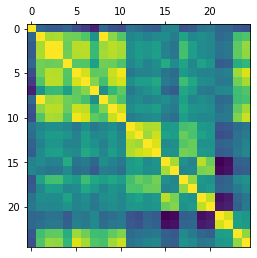

In [59]:
import matplotlib.pyplot as plt

plt.matshow(df_stats.corr())
plt.show()

In [60]:
df_stats.loc[2163, :]

Auid                          57213243676
mean_citations_per_year          3.181818
citation_count                         55
cited_by_count                         55
coauthor_count                         17
document_count                          5
h_index                                 3
affil                            Sickkids
publication_duration                   11
growth_rate                      1.818182
openaccess_sum                          0
Article_sum                      3.000000
SJR_median                       0.937000
SJR_mean                         0.960400
journal_h_index_median         131.000000
journal_h_index_mean           147.400000
author_count_mean                6.600000
author_count_median              7.000000
mean_citations_per_doc          11.000000
median_citations_per_doc        15.000000
chw_author_position_mean         2.200000
chw_author_position_median       3.000000
author_weight_mean               0.470258
author_weight_median             0

In [61]:
df_stats.to_excel('../Datasets/PCA_inputs_jan18.xlsx', index=False)